##### Copyright 2021 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Retraining an Image Classifier


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/tf2_image_retraining"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/hub/tutorials/tf2_image_retraining.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/image/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub models</a>
  </td>
</table>

## Introduction

Image classification models have millions of parameters. Training them from
scratch requires a lot of labeled training data and a lot of computing power. Transfer learning is a technique that shortcuts much of this by taking a piece of a model that has already been trained on a related task and reusing it in a new model.

This Colab demonstrates how to build a Keras model for classifying five species of flowers by using a pre-trained TF2 SavedModel from TensorFlow Hub for image feature extraction, trained on the much larger and more general ImageNet dataset. Optionally, the feature extractor can be trained ("fine-tuned") alongside the newly added classifier.

### Looking for a tool instead?

This is a TensorFlow coding tutorial. If you want a tool that just builds the TensorFlow or TFLite model for, take a look at the [make_image_classifier](https://github.com/tensorflow/hub/tree/master/tensorflow_hub/tools/make_image_classifier) command-line tool that gets [installed](https://www.tensorflow.org/hub/installation) by the PIP package `tensorflow-hub[make_image_classifier]`, or at [this](https://colab.sandbox.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/lite/model_maker/demo/image_classification.ipynb) TFLite colab.


In [2]:
!pip install tensorflow
!pip install tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 110.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 21.3 MB/s eta 0:00:00


## Setup

In [3]:
import itertools
import os

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.19.0
Hub version: 0.16.1
GPU is NOT AVAILABLE


Compatability issue between keras and tensorflow

In [4]:
import keras

In [5]:
# Use Keras 2.
version_fn = getattr(keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

## Select the TF2 SavedModel module to use

For starters, use [https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4](https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4). The same URL can be used in code to identify the SavedModel and in your browser to show its documentation. (Note that models in TF1 Hub format won't work here.)

You can find more TF2 models that generate image feature vectors [here](https://tfhub.dev/s?module-type=image-feature-vector&tf-version=tf2).

There are multiple possible models to try. All you need to do is select a different one on the cell below and follow up with the notebook.

In [6]:
#@title

model_name = "mobilenet_v2_100_224" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature-vector/4",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature-vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300,
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16#@param {type:"integer"}

Selected model: mobilenet_v2_100_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Input size (224, 224)


## Set up the Flowers dataset

Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

In [7]:
data_dir = keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 1s 0us/step


In [8]:
def build_dataset(subset):
  return keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=.20,
      subset=subset,
      label_mode="categorical",
      # Seed needs to provided when using validation_split and shuffle = True.
      # A fixed seed is used so that the validation set is stable across runs.
      seed=123,
      image_size=IMAGE_SIZE,
      batch_size=1)

train_ds = build_dataset("training")
class_names = tuple(train_ds.class_names)
train_size = train_ds.cardinality().numpy()
train_ds = train_ds.unbatch().batch(BATCH_SIZE)
train_ds = train_ds.repeat()

normalization_layer = keras.layers.Rescaling(1. / 255)
preprocessing_model = keras.Sequential([normalization_layer])
do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  preprocessing_model.add(
      keras.layers.RandomRotation(40))
  preprocessing_model.add(
      keras.layers.RandomTranslation(0, 0.2))
  preprocessing_model.add(
      keras.layers.RandomTranslation(0.2, 0))
  # Like the old keras.preprocessing.image.ImageDataGenerator(),
  # image sizes are fixed when reading, and then a random zoom is applied.
  # If all training inputs are larger than image_size, one could also use
  # RandomCrop with a batch size of 1 and rebatch later.
  preprocessing_model.add(
      keras.layers.RandomZoom(0.2, 0.2))
  preprocessing_model.add(
      keras.layers.RandomFlip(mode="horizontal"))
train_ds = train_ds.map(lambda images, labels:
                        (preprocessing_model(images), labels))

val_ds = build_dataset("validation")
valid_size = val_ds.cardinality().numpy()
val_ds = val_ds.unbatch().batch(BATCH_SIZE)
val_ds = val_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


## Defining the model

All it takes is to put a linear classifier on top of the `feature_extractor_layer` with the Hub module.

For speed, we start out with a non-trainable `feature_extractor_layer`, but you can also enable fine-tuning for greater accuracy.

In [9]:
do_fine_tuning = False #@param {type:"boolean"}

In [10]:
print("Building model with", model_handle)
model = keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(len(class_names),
                          kernel_regularizer=keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


#Calculating carbon emissions during model training

In [ ]:
!pip install codecarbon
from codecarbon import EmissionsTracker

## Training the model

In [12]:
model.compile(
  optimizer=keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
  loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [13]:
#start emissions tracking
tracker = EmissionsTracker()
tracker.start()

#Model training
steps_per_epoch = train_size // BATCH_SIZE
validation_steps = valid_size // BATCH_SIZE
hist = model.fit(
    train_ds,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=val_ds,
    validation_steps=validation_steps).history

#stop emissions tracking
emissions: float = tracker.stop()
print(f"Emissions during training: {emissions} kg CO2")

[codecarbon WARNING @ 21:09:46] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 21:09:46] [setup] RAM Tracking...
[codecarbon INFO @ 21:09:46] [setup] CPU Tracking...
[codecarbon WARNING @ 21:09:47] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 21:09:47] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 21:09:47] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 21:09:47] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 21:09:47] [setup] GPU Tracking...
[codecarbon INFO @ 21:09:47] No GPU found.
[codecarbon INFO @ 21:09:47] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Epoch 1/5
 10/183 [>.............................] - ETA: 2:53 - loss: 1.5627 - accuracy: 0.3938

[codecarbon INFO @ 21:10:02] Energy consumed for RAM : 0.000209 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:10:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:02] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 21:10:02] 0.000386 kWh of electricity used since the beginning.


 31/183 [====>.........................] - ETA: 2:03 - loss: 1.2170 - accuracy: 0.5948

[codecarbon INFO @ 21:10:17] Energy consumed for RAM : 0.000417 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:10:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:17] Energy consumed for All CPU : 0.000355 kWh
[codecarbon INFO @ 21:10:17] 0.000772 kWh of electricity used since the beginning.


 52/183 [=======>......................] - ETA: 1:41 - loss: 1.0739 - accuracy: 0.6839

[codecarbon INFO @ 21:10:32] Energy consumed for RAM : 0.000625 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:10:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:32] Energy consumed for All CPU : 0.000532 kWh
[codecarbon INFO @ 21:10:32] 0.001157 kWh of electricity used since the beginning.


 74/183 [===========>..................] - ETA: 1:21 - loss: 1.0024 - accuracy: 0.7247

[codecarbon INFO @ 21:10:47] Energy consumed for RAM : 0.000834 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:10:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:10:47] Energy consumed for All CPU : 0.000709 kWh
[codecarbon INFO @ 21:10:47] 0.001543 kWh of electricity used since the beginning.


 97/183 [==============>...............] - ETA: 1:02 - loss: 0.9568 - accuracy: 0.7442

[codecarbon INFO @ 21:11:02] Energy consumed for RAM : 0.001041 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:11:02] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:11:02] Energy consumed for All CPU : 0.000885 kWh
[codecarbon INFO @ 21:11:02] 0.001926 kWh of electricity used since the beginning.


120/183 [==================>...........] - ETA: 44s - loss: 0.9372 - accuracy: 0.7531

[codecarbon INFO @ 21:11:17] Energy consumed for RAM : 0.001248 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:11:17] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:11:17] Energy consumed for All CPU : 0.001061 kWh
[codecarbon INFO @ 21:11:17] 0.002309 kWh of electricity used since the beginning.


143/183 [======================>.......] - ETA: 27s - loss: 0.9175 - accuracy: 0.7640

[codecarbon INFO @ 21:11:32] Energy consumed for RAM : 0.001456 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:11:32] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 21:11:32] Energy consumed for All CPU : 0.001239 kWh
[codecarbon INFO @ 21:11:32] 0.002695 kWh of electricity used since the beginning.


166/183 [==========================>...] - ETA: 11s - loss: 0.8999 - accuracy: 0.7733

[codecarbon INFO @ 21:11:47] Energy consumed for RAM : 0.001663 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:11:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:11:47] Energy consumed for All CPU : 0.001416 kWh
[codecarbon INFO @ 21:11:47] 0.003079 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:11:47] 0.011602 g.CO2eq/s mean an estimation of 365.8706930486271 kg.CO2eq/year


183/183 [==============================] - ETA: 0s - loss: 0.8902 - accuracy: 0.7790

[codecarbon INFO @ 21:12:02] Energy consumed for RAM : 0.001870 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:12:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:12:02] Energy consumed for All CPU : 0.001593 kWh
[codecarbon INFO @ 21:12:02] 0.003464 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:12:17] Energy consumed for RAM : 0.002079 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:12:17] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:12:17] Energy consumed for All CPU : 0.001770 kWh
[codecarbon INFO @ 21:12:17] 0.003849 kWh of electricity used since the beginning.


183/183 [==============================] - 162s 858ms/step - loss: 0.8902 - accuracy: 0.7790 - val_loss: 0.6875 - val_accuracy: 0.8806
Epoch 2/5
  5/183 [..............................] - ETA: 2:13 - loss: 0.6805 - accuracy: 0.8750

[codecarbon INFO @ 21:12:32] Energy consumed for RAM : 0.002287 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:12:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:12:32] Energy consumed for All CPU : 0.001947 kWh
[codecarbon INFO @ 21:12:32] 0.004234 kWh of electricity used since the beginning.


 28/183 [===>..........................] - ETA: 1:42 - loss: 0.7286 - accuracy: 0.8591

[codecarbon INFO @ 21:12:47] Energy consumed for RAM : 0.002495 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:12:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:12:47] Energy consumed for All CPU : 0.002124 kWh
[codecarbon INFO @ 21:12:47] 0.004620 kWh of electricity used since the beginning.


 51/183 [=======>......................] - ETA: 1:26 - loss: 0.7240 - accuracy: 0.8540

[codecarbon INFO @ 21:13:02] Energy consumed for RAM : 0.002704 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:13:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:13:02] Energy consumed for All CPU : 0.002301 kWh
[codecarbon INFO @ 21:13:02] 0.005005 kWh of electricity used since the beginning.


 74/183 [===========>..................] - ETA: 1:11 - loss: 0.7136 - accuracy: 0.8665

[codecarbon INFO @ 21:13:17] Energy consumed for RAM : 0.002911 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:13:17] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:13:17] Energy consumed for All CPU : 0.002477 kWh
[codecarbon INFO @ 21:13:17] 0.005388 kWh of electricity used since the beginning.


 96/183 [==============>...............] - ETA: 57s - loss: 0.7062 - accuracy: 0.8704

[codecarbon INFO @ 21:13:32] Energy consumed for RAM : 0.003118 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:13:32] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:13:32] Energy consumed for All CPU : 0.002653 kWh
[codecarbon INFO @ 21:13:32] 0.005771 kWh of electricity used since the beginning.


118/183 [==================>...........] - ETA: 43s - loss: 0.7114 - accuracy: 0.8654

[codecarbon INFO @ 21:13:47] Energy consumed for RAM : 0.003326 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:13:47] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 21:13:47] Energy consumed for All CPU : 0.002832 kWh
[codecarbon INFO @ 21:13:47] 0.006158 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:13:47] 0.011601 g.CO2eq/s mean an estimation of 365.85515357318167 kg.CO2eq/year


141/183 [======================>.......] - ETA: 27s - loss: 0.7117 - accuracy: 0.8665

[codecarbon INFO @ 21:14:02] Energy consumed for RAM : 0.003533 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:14:02] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:14:02] Energy consumed for All CPU : 0.003008 kWh
[codecarbon INFO @ 21:14:02] 0.006541 kWh of electricity used since the beginning.


164/183 [=========================>....] - ETA: 12s - loss: 0.7123 - accuracy: 0.8693

[codecarbon INFO @ 21:14:17] Energy consumed for RAM : 0.003743 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:14:17] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 21:14:17] Energy consumed for All CPU : 0.003186 kWh
[codecarbon INFO @ 21:14:17] 0.006928 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.8668

[codecarbon INFO @ 21:14:32] Energy consumed for RAM : 0.003951 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:14:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:14:32] Energy consumed for All CPU : 0.003363 kWh
[codecarbon INFO @ 21:14:32] 0.007314 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:14:47] Energy consumed for RAM : 0.004159 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:14:47] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:14:47] Energy consumed for All CPU : 0.003540 kWh
[codecarbon INFO @ 21:14:47] 0.007699 kWh of electricity used since the beginning.


183/183 [==============================] - 151s 828ms/step - loss: 0.7155 - accuracy: 0.8668 - val_loss: 0.6953 - val_accuracy: 0.8847
Epoch 3/5
  4/183 [..............................] - ETA: 1:41 - loss: 0.6243 - accuracy: 0.9107

[codecarbon INFO @ 21:15:02] Energy consumed for RAM : 0.004368 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:15:02] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 21:15:02] Energy consumed for All CPU : 0.003718 kWh
[codecarbon INFO @ 21:15:02] 0.008086 kWh of electricity used since the beginning.


 27/183 [===>..........................] - ETA: 1:40 - loss: 0.6779 - accuracy: 0.8892

[codecarbon INFO @ 21:15:17] Energy consumed for RAM : 0.004574 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:15:17] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:15:17] Energy consumed for All CPU : 0.003894 kWh
[codecarbon INFO @ 21:15:17] 0.008468 kWh of electricity used since the beginning.


 49/183 [=======>......................] - ETA: 1:27 - loss: 0.6650 - accuracy: 0.8982

[codecarbon INFO @ 21:15:32] Energy consumed for RAM : 0.004783 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:15:32] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:15:32] Energy consumed for All CPU : 0.004071 kWh
[codecarbon INFO @ 21:15:32] 0.008854 kWh of electricity used since the beginning.


 73/183 [==========>...................] - ETA: 1:11 - loss: 0.6481 - accuracy: 0.9069

[codecarbon INFO @ 21:15:47] Energy consumed for RAM : 0.004992 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:15:48] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 21:15:48] Energy consumed for All CPU : 0.004249 kWh
[codecarbon INFO @ 21:15:48] 0.009242 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:15:48] 0.011622 g.CO2eq/s mean an estimation of 366.5168915748421 kg.CO2eq/year


 97/183 [==============>...............] - ETA: 55s - loss: 0.6439 - accuracy: 0.9080

[codecarbon INFO @ 21:16:02] Energy consumed for RAM : 0.005201 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:16:02] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:16:03] Energy consumed for All CPU : 0.004426 kWh
[codecarbon INFO @ 21:16:03] 0.009627 kWh of electricity used since the beginning.


119/183 [==================>...........] - ETA: 41s - loss: 0.6519 - accuracy: 0.9030

[codecarbon INFO @ 21:16:17] Energy consumed for RAM : 0.005409 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:16:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:16:18] Energy consumed for All CPU : 0.004603 kWh
[codecarbon INFO @ 21:16:18] 0.010012 kWh of electricity used since the beginning.


142/183 [======================>.......] - ETA: 26s - loss: 0.6555 - accuracy: 0.9002

[codecarbon INFO @ 21:16:33] Energy consumed for RAM : 0.005617 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:16:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:16:33] Energy consumed for All CPU : 0.004780 kWh
[codecarbon INFO @ 21:16:33] 0.010398 kWh of electricity used since the beginning.


165/183 [==========================>...] - ETA: 11s - loss: 0.6582 - accuracy: 0.9008

[codecarbon INFO @ 21:16:48] Energy consumed for RAM : 0.005826 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:16:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:16:48] Energy consumed for All CPU : 0.004958 kWh
[codecarbon INFO @ 21:16:48] 0.010783 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.8993

[codecarbon INFO @ 21:17:03] Energy consumed for RAM : 0.006033 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:17:03] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:03] Energy consumed for All CPU : 0.005134 kWh
[codecarbon INFO @ 21:17:03] 0.011166 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:18] Energy consumed for RAM : 0.006241 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:17:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:18] Energy consumed for All CPU : 0.005311 kWh
[codecarbon INFO @ 21:17:18] 0.011551 kWh of electricity used since the beginning.


183/183 [==============================] - 148s 809ms/step - loss: 0.6612 - accuracy: 0.8993 - val_loss: 0.6798 - val_accuracy: 0.8917
Epoch 4/5
  7/183 [>.............................] - ETA: 1:51 - loss: 0.6895 - accuracy: 0.9038

[codecarbon INFO @ 21:17:33] Energy consumed for RAM : 0.006449 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:17:33] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:33] Energy consumed for All CPU : 0.005489 kWh
[codecarbon INFO @ 21:17:33] 0.011938 kWh of electricity used since the beginning.


 30/183 [===>..........................] - ETA: 1:39 - loss: 0.6593 - accuracy: 0.9131

[codecarbon INFO @ 21:17:48] Energy consumed for RAM : 0.006656 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:17:48] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:17:48] Energy consumed for All CPU : 0.005665 kWh
[codecarbon INFO @ 21:17:48] 0.012321 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:17:48] 0.011605 g.CO2eq/s mean an estimation of 365.9654801684456 kg.CO2eq/year


 53/183 [=======>......................] - ETA: 1:24 - loss: 0.6419 - accuracy: 0.9190

[codecarbon INFO @ 21:18:03] Energy consumed for RAM : 0.006863 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:18:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:03] Energy consumed for All CPU : 0.005842 kWh
[codecarbon INFO @ 21:18:03] 0.012705 kWh of electricity used since the beginning.


 76/183 [===========>..................] - ETA: 1:09 - loss: 0.6296 - accuracy: 0.9263

[codecarbon INFO @ 21:18:18] Energy consumed for RAM : 0.007070 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:18:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:18] Energy consumed for All CPU : 0.006019 kWh
[codecarbon INFO @ 21:18:18] 0.013089 kWh of electricity used since the beginning.


 99/183 [===============>..............] - ETA: 54s - loss: 0.6300 - accuracy: 0.9213

[codecarbon INFO @ 21:18:33] Energy consumed for RAM : 0.007279 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:18:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:33] Energy consumed for All CPU : 0.006196 kWh
[codecarbon INFO @ 21:18:33] 0.013474 kWh of electricity used since the beginning.


123/183 [===================>..........] - ETA: 38s - loss: 0.6401 - accuracy: 0.9184

[codecarbon INFO @ 21:18:48] Energy consumed for RAM : 0.007487 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:18:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:18:48] Energy consumed for All CPU : 0.006373 kWh
[codecarbon INFO @ 21:18:48] 0.013860 kWh of electricity used since the beginning.


146/183 [======================>.......] - ETA: 23s - loss: 0.6400 - accuracy: 0.9162

[codecarbon INFO @ 21:19:03] Energy consumed for RAM : 0.007695 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:19:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:03] Energy consumed for All CPU : 0.006550 kWh
[codecarbon INFO @ 21:19:03] 0.014245 kWh of electricity used since the beginning.


170/183 [==========================>...] - ETA: 8s - loss: 0.6428 - accuracy: 0.9141

[codecarbon INFO @ 21:19:18] Energy consumed for RAM : 0.007903 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:19:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:18] Energy consumed for All CPU : 0.006727 kWh
[codecarbon INFO @ 21:19:18] 0.014630 kWh of electricity used since the beginning.


183/183 [==============================] - ETA: 0s - loss: 0.6431 - accuracy: 0.9140

[codecarbon INFO @ 21:19:33] Energy consumed for RAM : 0.008112 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:19:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:33] Energy consumed for All CPU : 0.006904 kWh
[codecarbon INFO @ 21:19:33] 0.015016 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:48] Energy consumed for RAM : 0.008319 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:19:48] Delta energy consumed for CPU with constant : 0.000176 kWh, power : 42.5 W
[codecarbon INFO @ 21:19:48] Energy consumed for All CPU : 0.007080 kWh
[codecarbon INFO @ 21:19:48] 0.015399 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:19:48] 0.011608 g.CO2eq/s mean an estimation of 366.08258691506177 kg.CO2eq/year


183/183 [==============================] - 148s 808ms/step - loss: 0.6431 - accuracy: 0.9140 - val_loss: 0.6843 - val_accuracy: 0.8931
Epoch 5/5
 11/183 [>.............................] - ETA: 1:41 - loss: 0.6218 - accuracy: 0.9226

[codecarbon INFO @ 21:20:03] Energy consumed for RAM : 0.008527 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:20:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:20:03] Energy consumed for All CPU : 0.007257 kWh
[codecarbon INFO @ 21:20:03] 0.015784 kWh of electricity used since the beginning.


 35/183 [====>.........................] - ETA: 1:33 - loss: 0.6177 - accuracy: 0.9185

[codecarbon INFO @ 21:20:18] Energy consumed for RAM : 0.008735 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:20:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:20:18] Energy consumed for All CPU : 0.007434 kWh
[codecarbon INFO @ 21:20:18] 0.016169 kWh of electricity used since the beginning.


 58/183 [========>.....................] - ETA: 1:19 - loss: 0.6099 - accuracy: 0.9272

[codecarbon INFO @ 21:20:33] Energy consumed for RAM : 0.008943 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:20:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:20:33] Energy consumed for All CPU : 0.007611 kWh
[codecarbon INFO @ 21:20:33] 0.016555 kWh of electricity used since the beginning.


 82/183 [============>.................] - ETA: 1:04 - loss: 0.6111 - accuracy: 0.9287

[codecarbon INFO @ 21:20:48] Energy consumed for RAM : 0.009153 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:20:48] Delta energy consumed for CPU with constant : 0.000178 kWh, power : 42.5 W
[codecarbon INFO @ 21:20:48] Energy consumed for All CPU : 0.007789 kWh
[codecarbon INFO @ 21:20:48] 0.016942 kWh of electricity used since the beginning.


106/183 [================>.............] - ETA: 48s - loss: 0.6096 - accuracy: 0.9289

[codecarbon INFO @ 21:21:03] Energy consumed for RAM : 0.009361 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:21:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:21:03] Energy consumed for All CPU : 0.007967 kWh
[codecarbon INFO @ 21:21:03] 0.017328 kWh of electricity used since the beginning.


130/183 [====================>.........] - ETA: 33s - loss: 0.6105 - accuracy: 0.9276

[codecarbon INFO @ 21:21:18] Energy consumed for RAM : 0.009569 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:21:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:21:18] Energy consumed for All CPU : 0.008144 kWh
[codecarbon INFO @ 21:21:18] 0.017713 kWh of electricity used since the beginning.


153/183 [========================>.....] - ETA: 18s - loss: 0.6159 - accuracy: 0.9242

[codecarbon INFO @ 21:21:33] Energy consumed for RAM : 0.009778 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:21:33] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:21:33] Energy consumed for All CPU : 0.008321 kWh
[codecarbon INFO @ 21:21:33] 0.018098 kWh of electricity used since the beginning.


177/183 [============================>.] - ETA: 3s - loss: 0.6175 - accuracy: 0.9228

[codecarbon INFO @ 21:21:48] Energy consumed for RAM : 0.009986 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:21:48] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:21:48] Energy consumed for All CPU : 0.008498 kWh
[codecarbon INFO @ 21:21:48] 0.018484 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:21:48] 0.011627 g.CO2eq/s mean an estimation of 366.6647714539035 kg.CO2eq/year


183/183 [==============================] - ETA: 0s - loss: 0.6194 - accuracy: 0.9212

[codecarbon INFO @ 21:22:03] Energy consumed for RAM : 0.010194 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:22:03] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:22:03] Energy consumed for All CPU : 0.008675 kWh
[codecarbon INFO @ 21:22:03] 0.018869 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:22:18] Energy consumed for RAM : 0.010403 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:22:18] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 21:22:18] Energy consumed for All CPU : 0.008852 kWh
[codecarbon INFO @ 21:22:18] 0.019254 kWh of electricity used since the beginning.


183/183 [==============================] - 145s 795ms/step - loss: 0.6194 - accuracy: 0.9212 - val_loss: 0.6707 - val_accuracy: 0.8931


[codecarbon INFO @ 21:22:21] Energy consumed for RAM : 0.010446 kWh. RAM Power : 50.0 W
[codecarbon INFO @ 21:22:21] Delta energy consumed for CPU with constant : 0.000037 kWh, power : 42.5 W
[codecarbon INFO @ 21:22:21] Energy consumed for All CPU : 0.008889 kWh
[codecarbon INFO @ 21:22:21] 0.019335 kWh of electricity used since the beginning.


Emissions during training: 0.008751440912076877 kg CO2


In [14]:
emissions_data = tracker.final_emissions_data
print(f"Energy consumed: {emissions_data.energy_consumed:.6f} kWh")
print(f"Execution Time: {emissions_data.duration:.2f} seconds")
print(f"Emissions: {emissions_data.emissions} kg CO2")

Energy consumed: 0.019335 kWh
Execution Time: 753.68 seconds
Emissions: 0.008751440912076877 kg CO2


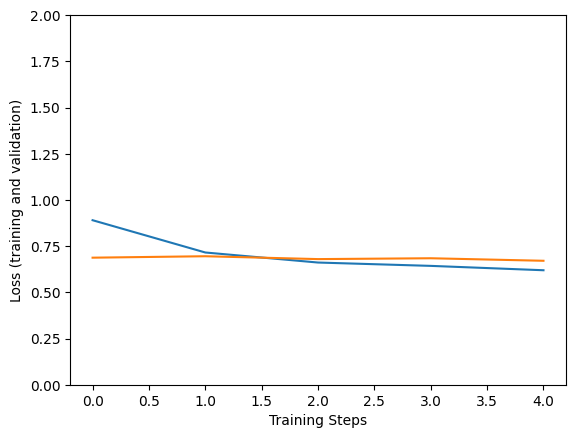

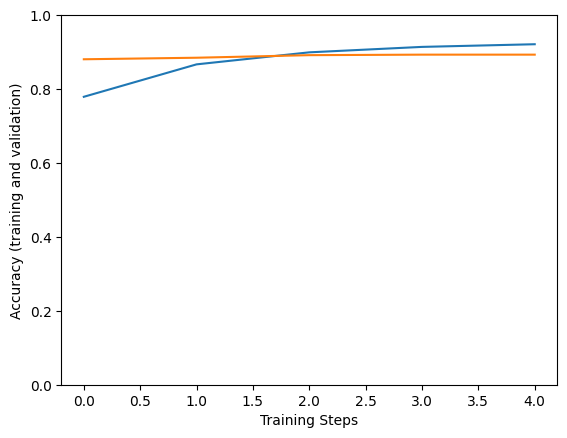

In [15]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

Try out the model on an image from the validation data:

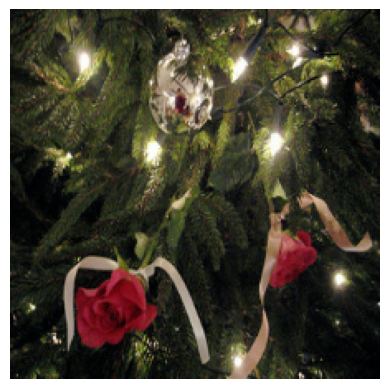

1/1 [==============================] - 0s 38ms/step
True label: roses
Predicted label: roses


In [18]:
x, y = next(iter(val_ds))
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + class_names[true_index])
print("Predicted label: " + class_names[predicted_index])